In [1]:
import numpy as np
import pandas as pd

from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials

In [2]:
df, price_series, timestamps = load_price_data(
    csv_path   = "../data/raw/dayahead_2024_11.csv",
    resolution = "15min",
)

df = df.loc["2024-11-01":"2024-11-07"] # 672 steps (1 week)
price_week = df["Day Ahead Auktion"].values.astype(np.float32)
timestamps_week = df.index

In [3]:
# Create BatteryEnv with 15-minute time step (continuous actions)
env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,               # 15 min
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,  # continuous for SAC
    random_seed=42,
)

# Wrap with Monitor so SB3 can track episode rewards/lengths
train_env = Monitor(env)

model = SAC("MlpPolicy", train_env, verbose=1)

model.learn(
    total_timesteps=5_000,
    log_interval=10,
    progress_bar=True,
)

print("Training completed.")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 4,999/5,000  [ 0:01:39 < 0:00:01 , 49 it/s ]

Training completed.


In [4]:
eval_env = BatteryEnv(
    price_series=price_week,
    demand_series=None,
    timestamps=timestamps_week,
    dt_hours=0.25,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,
    random_seed=123,
)

obs, info = eval_env.reset()

soc_list = []
soh_list = []
reward_list = []
price_true_list = []
action_list_cont = []

revenue_list = []
deg_cost_list = []
penalty_list = []

n_steps = len(price_week)  # one full week (672 steps)

for t in range(n_steps):
    # Let SAC choose an action
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = eval_env.step(action)
    
    soc_list.append(obs[0])                    # SoC
    soh_list.append(obs[1])                    # SoH
    reward_list.append(reward)
    price_true_list.append(info["price_true"])
    action_list_cont.append(float(action[0]))  # store kW command

    # Financial components
    revenue_list.append(info["revenue_eur"])
    deg_cost_list.append(info["deg_cost_eur"])
    penalty_list.append(info["penalty_eur"])

    if terminated or truncated:
        print(f"Episode finished at step {t}")
        break

Episode finished at step 671


=== Financial Summary ===
Total revenue    (EUR): 20.364
Degradation cost (EUR): 3.201
Penalty cost     (EUR): 0.000
Net profit       (EUR): 17.163


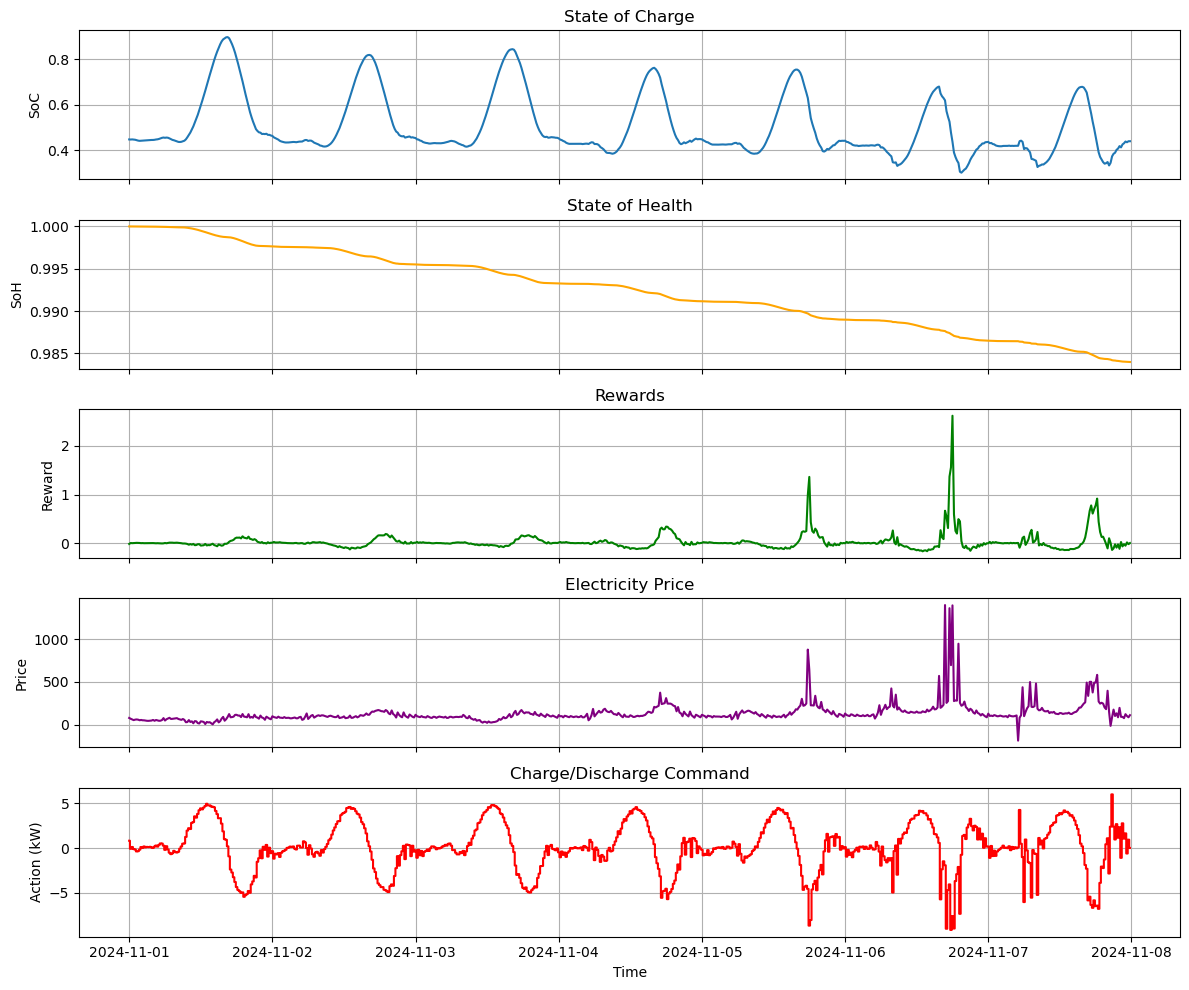

In [5]:
results = evaluate_financials(
    revenue_list,
    deg_cost_list,
    penalty_list,
)

plot_bess_rollout(
    soc_list=soc_list,
    soh_list=soh_list,
    reward_list=reward_list,
    price_list=price_true_list,
    action_list=action_list_cont,
    timestamps=timestamps_week[:len(soc_list)],
)